In [1]:
# %% import package to use
import datatable
import pandas as pd
import xgboost as xgb
from IPython.display import display
import numpy as np
from xgbse.metrics import concordance_index
pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Results"
df_orig = datatable.fread(os.path.join(DATA_PATH, 'MF_general_eq_for_surv.csv'), na_strings=['', 'NA']).to_pandas()
df_orig['lower_bound'] = df_orig['delta_time']
df_orig['upper_bound'] = np.where(df_orig['death'] == 1, df_orig['lower_bound'], +np.inf)
df_orig.head()

,SM_DATE,HPCID,sex,AGE,percentage_fat,Height,Weight,BMI,MVPA,rest_HR,Smoke,CRF,비만도,Muscle_mass,복부지방율,부종검사,Muscle_mass(RA),Muscle_mass(LA),Muscle_mass(BODY),Muscle_mass(RL),Muscle_mass(LL),체지방량,체수분량,제지방량,CRP,CHOLESTEROL,TG,max_heart_rate,BMI_cal,ASMI,VO2max,death,delta_time,Diabetes,Hypertension,HTN_med,Hyperlipidemia,Hepatatis,ALC,HDL_C,LDL_C,MBP,visit_num,ABRP_VO2max,ABRP_CRF,ABR_VO2max,ABR_CRF,ABP_VO2max,ABP_CRF,APRP_VO2max,APRP_CRF,APR_VO2max,APR_CRF,APP_VO2max,APP_CRF,CRF_tertile,CRF_tertile_nm,ABRP_CRF_tertile,ABRP_CRF_tertile_nm,ABR_CRF_tertile,ABR_CRF_tertile_nm,ABP_CRF_tertile,ABP_CRF_tertile_nm,APRP_CRF_tertile,APRP_CRF_tertile_nm,APR_CRF_tertile,APR_CRF_tertile_nm,APP_CRF_tertile,APP_CRF_tertile_nm,CRF_qualtile,CRF_qualtile_nm,ABRP_CRF_qualtile,ABRP_CRF_qualtile_nm,ABR_CRF_qualtile,ABR_CRF_qualtile_nm,ABP_CRF_qualtile,ABP_CRF_qualtile_nm,APRP_CRF_qualtile,APRP_CRF_qualtile_nm,APR_CRF_qualtile,APR_CRF_qualtile_nm,APP_CRF_qualtile,APP_CRF_qualtile_nm,lower_bound,upper_bound
0,2015-08-03,0107034B1E4539,True,55,33.1,153.4,56.6,24.1,False,58.0,False,7.1,115.0,35.8,0.88,0.340,1.94,1.89,17.26,5.53,5.51,18.7,27.9,37.9,0.04,223.0,76.0,119.0,24.052804,6.319173,24.85,False,1415.0,False,False,False,True,False,False,60.0,156.0,80.0,1.0,25.174759,7.192788,25.432659,7.266474,24.742318,7.069234,24.818660,7.091046,24.987268,7.139220,24.405508,6.973002,T1,"(3.799, 8.5]",T1,"(5.887, 8.929]",T1,"(5.887, 8.929]",T1,"(6.263, 8.977]",T1,"(5.624, 8.892]",T1,"(5.622, 8.913]",T1,"(5.792999999999999, 8.927]",Q1,"(3.799, 8.2]",Q1,"(5.887, 8.737]",Q1,"(5.896, 8.782]",Q1,"(6.263, 8.808]",Q1,"(5.624, 8.692]",Q1,"(5.622, 8.714]",Q1,"(5.792999999999999, 8.728]",1415.0,inf
1,2012-11-08,01070555203C39,False,29,22.3,169.5,67.8,23.6,False,64.0,False,11.4,107.0,49.8,0.86,0.314,2.86,2.74,23.58,8.40,8.21,15.1,38.5,52.7,0.05,274.0,97.0,175.0,23.598820,7.730528,39.90,False,2413.0,False,False,False,True,True,True,67.0,197.0,92.2,1.0,36.615164,10.461475,36.838672,10.525335,36.492219,10.426348,36.208315,10.345233,36.394904,10.398544,36.077991,10.307997,T3,"(9.6, 14.0]",T3,"(9.473, 11.932]",T3,"(9.473, 11.932]",T3,"(9.444, 11.86]",T3,"(9.485, 12.442]",T3,"(9.491, 12.024]",T3,"(9.471, 12.071]",Q4,"(9.9, 14.0]",Q4,"(9.627, 11.932]",Q4,"(9.606, 11.684]",Q4,"(9.585, 11.86]",Q4,"(9.649, 12.442]",Q4,"(9.642, 12.024]",Q4,"(9.626, 12.071]",2413.0,inf
2,2012-06-28,0107062321322E,False,36,22.4,176.1,69.4,22.4,False,66.0,True,8.3,102.0,50.9,0.87,0.339,3.09,3.02,24.71,8.45,8.31,15.5,39.7,53.9,1.63,197.0,144.0,156.0,22.379004,7.374753,29.05,False,2546.0,False,True,False,True,False,False,36.0,142.0,102.8,1.0,35.374150,10.106900,35.606388,10.173254,35.572625,10.163607,34.699210,9.914060,34.896320,9.970377,34.823576,9.949593,T1,"(3.799, 8.5]",T3,"(9.473, 11.932]",T3,"(9.473, 11.932]",T3,"(9.444, 11.86]",T3,"(9.485, 12.442]",T3,"(9.491, 12.024]",T3,"(9.471, 12.071]",Q2,"(8.2, 9.1]",Q4,"(9.627, 11.932]",Q4,"(9.606, 11.684]",Q4,"(9.585, 11.86]",Q4,"(9.649, 12.442]",Q4,"(9.642, 12.024]",Q4,"(9.626, 12.071]",2546.0,inf
3,2012-01-11,010706444B4537,False,50,22.9,171.2,70.5,24.1,True,63.0,False,12.3,109.0,51.4,0.92,0.326,3.00,3.03,24.58,8.33,8.55,16.1,39.9,54.4,0.05,182.0,130.0,158.0,24.053684,7.816594,43.05,False,2715.0,False,True,False,False,False,False,51.0,111.0,109.4,1.0,34.556561,9.873303,32.691000,9.340286,34.782772,9.937935,34.072775,9.735079,32.484872,9.281392,34.222220,9.777777,T3,"(9.6, 14.0]",T3,"(9.473, 11.932]",T2,"(9.473, 11.932]",T3,"(9.444, 11.86]",T3,"(9.485, 12.442]",T2,"(8.913, 9.491]",T3,"(9.471, 12.071]",Q4,"(9.9, 14.0]",Q4,"(9.627, 11.932]",Q3,"(9.234, 9.606]",Q4,"(9.585, 11.86]",Q4,"(9.649, 12.442]",Q3,"(9.224, 9.642]",Q4,"(9.626, 12.071]",2715.0,inf
4,2011-06-15,0107064D403C37,False,37,17.9,171.1,71.7,24.5,False,61.0,True,8.2,111.0,55.9,0.88,0.327,3.57,3.48,27.18,9.27,9.08,12.8,43.4,58.9,0.03,205.0,254.0,166.0,24.491712,8.676283,28.70,False,2925.0,False,True,False,False,False,True,45.0,129.0,108.0,1.0,35.066378,10.018965,35.338643,10.096755,34.704675,9.915621,3

In [3]:
feature_names = ['AGE', 'sex', 'Smoke', 'ALC', 'CRP', 'TG', 'Diabetes', 'Hypertension', 
                 'Hyperlipidemia', 'HDL_C', 'LDL_C', 'MBP', 'ABRP_CRF']

"""
Option 1: Adjust age
Option 2: Adjust sex
Option 3: Adjust age and sex
Option 3: Non-adjust age and sex
"""

'\nOption 1: Adjust age\nOption 2: Adjust sex\nOption 3: Adjust age and sex\nOption 3: Non-adjust age and sex\n'

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_orig, train_size=0.8, stratify=df_orig['death'], random_state=1005)

In [5]:
from tqdm.notebook import tqdm
from lifelines.utils import concordance_index
from sklearn.model_selection import RepeatedStratifiedKFold
import numpy as np
import pickle

hyper_param_depth = [2, 3, 4, 5]
hyper_param_lr = [0.001, 0.0001]

# hyper_param_depth = [2]
# hyper_param_lr = [0.1]

results = {}

for hyper_depth in tqdm(hyper_param_depth, desc= 'depth'):

    for hyper_lr in tqdm(hyper_param_lr, desc= 'l_rate'):

        skf = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

        scores = []

        for train_index, validation_index in tqdm(skf.split(train_set, train_set['death']), desc='fold'):
                X_train = train_set.iloc[train_index][feature_names].values
                dtrain = xgb.DMatrix(X_train)
                dtrain.set_float_info('label_lower_bound', train_set.iloc[train_index]['lower_bound'].values)
                dtrain.set_float_info('label_upper_bound', train_set.iloc[train_index]['upper_bound'].values)

                X_validation = train_set.iloc[validation_index][feature_names].values
                dvalidation = xgb.DMatrix(X_validation)
                dvalidation.set_float_info('label_lower_bound', train_set.iloc[validation_index]['lower_bound'].values)
                dvalidation.set_float_info('label_upper_bound', train_set.iloc[validation_index]['upper_bound'].values)

                params = {'objective': 'survival:aft',
                    'eval_metric': 'aft-nloglik',
                    'aft_loss_distribution': 'normal',
                    'aft_loss_distribution_scale': 1.20,
                    'tree_method': 'gpu_hist', 
                    'gpu_id': '0',
                    'learning_rate': hyper_lr, 
                    'max_depth': hyper_depth}

                model_xgb = xgb.train(params, dtrain, 
                                    num_boost_round=20000, 
                                    evals=[(dvalidation, 'validation')], 
                                    verbose_eval=0, 
                                    early_stopping_rounds=1000)
                c_index = concordance_index(train_set.iloc[validation_index]['lower_bound'].values, 
                            model_xgb.predict(dvalidation), 
                            event_observed=train_set.iloc[validation_index]['death'].astype(int))

                scores.append(c_index)

        result = {'max_depth': hyper_depth, 'learning_rate': hyper_lr, 'scores':scores, 'mean_score':np.mean(scores), 'std_score':np.std(scores)}
        results["depth_" + str(hyper_depth) + "_lr_" + str(hyper_lr)] = result
    
with open('../survival_xg_results.pickle', 'wb') as file_nm:
    pickle.dump(results, file_nm, protocol=pickle.HIGHEST_PROTOCOL)

# with open('../survival_xg_results.pickle', 'rb') as file_nm:
#     loaded_results = pickle.load(file_nm)

# results == loaded_results
    

In [6]:
results

{'depth_2_lr_0.001': {'max_depth': 2,
  'learning_rate': 0.001,
  'scores': [0.5667051134179162,
   0.5131623931623932,
   0.2992534218166736,
   0.8870311793944872,
   0.5070702607158639,
   0.41185527328714394,
   0.5327009485771343,
   0.8253382533825339,
   0.8000848896434635,
   0.6980676328502415],
  'mean_score': 0.6041269366247851,
  'std_score': 0.1817433615508376},
 'depth_2_lr_0.0001': {'max_depth': 2,
  'learning_rate': 0.0001,
  'scores': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
  'mean_score': 0.5,
  'std_score': 0.0},
 'depth_3_lr_0.001': {'max_depth': 3,
  'learning_rate': 0.001,
  'scores': [0.36863379143088115,
   0.4307600477516912,
   0.521112600536193,
   0.8788228505481823,
   0.7025641025641025,
   0.525679758308157,
   0.49621873182082604,
   0.856921287320667,
   0.31095962244362874,
   0.8962432915921288],
  'mean_score': 0.5987916084316458,
  'std_score': 0.2074246143106886},
 'depth_3_lr_0.0001': {'max_depth': 3,
  'learning_rate': 0.0001,
  'scor

## Evaluation

In [1]:
# %% import package to use
import datatable
import pandas as pd
import xgboost as xgb
from IPython.display import display
import numpy as np
from xgbse.metrics import concordance_index
from lifelines.utils import concordance_index
import pickle
pd.set_option('display.max_columns', None)

DATA_PATH = "/home/lkh256/Studio/VO2max_Prediction/Results"
df_orig = datatable.fread(os.path.join(DATA_PATH, 'MF_general_eq_for_surv.csv'), na_strings=['', 'NA']).to_pandas()
df_orig['lower_bound'] = df_orig['delta_time']
df_orig['upper_bound'] = np.where(df_orig['death'] == 1, df_orig['lower_bound'], +np.inf)
df_orig.head()

feature_names = ['AGE', 'sex', 'Smoke', 'ALC', 'CRP', 'TG', 'Diabetes', 'Hypertension', 
                 'Hyperlipidemia', 'HDL_C', 'LDL_C', 'MBP', 'ABRP_CRF']

"""
Option 1: Adjust age
Option 2: Adjust sex
Option 3: Adjust age and sex
Option 3: Non-adjust age and sex
"""

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df_orig, train_size=0.8, stratify=df_orig['death'], random_state=1005)

In [4]:
with open('../MF_survival_xg_results.pickle', 'rb') as file_nm:
    results = pickle.load(file_nm)

In [6]:
df_results = pd.DataFrame()
for condition in results:
    df_results = pd.concat((df_results, pd.DataFrame(results[condition])), axis=0)
best_param = df_results[df_results['mean_score'] == df_results['mean_score'].max()][['max_depth', 'learning_rate', 'lambda', 'gamma', 'mean_score']].drop_duplicates()
best_param.head()

,max_depth,learning_rate,lambda,gamma,mean_score
0,4,0.001,3,0.5,0.680108


In [8]:
X_train = train_set[feature_names].values
dtrain = xgb.DMatrix(X_train)
dtrain.set_float_info('label_lower_bound', train_set['lower_bound'].values)
dtrain.set_float_info('label_upper_bound', train_set['upper_bound'].values)

X_test = test_set[feature_names].values
dtest = xgb.DMatrix(X_test)
dtest.set_float_info('label_lower_bound', test_set['lower_bound'].values)
dtest.set_float_info('label_upper_bound', test_set['upper_bound'].values)

params = {'objective': 'survival:aft', 
        'eval_metric': 'aft-nloglik', 
        'aft_loss_distribution': 'normal', 
        'aft_loss_distribution_scale': 1.20,
        'tree_method': 'gpu_hist', 
        'gpu_id': '0',
        'learning_rate': best_param['learning_rate'].values[0], 
        'max_depth': best_param['max_depth'].values[0],
        'lambda': best_param['lambda'].values[0],
        'gamma': best_param['gamma'].values[0]}

model_xgb = xgb.train(params, dtrain, num_boost_round=20000, evals=[(dtest, 'test')], verbose_eval=0, early_stopping_rounds=1000)

In [9]:
c_index = concordance_index(test_set['lower_bound'].values, 
                            model_xgb.predict(dtest), 
                            event_observed=test_set['death'].astype(int))
print(c_index)

0.5919793966151582


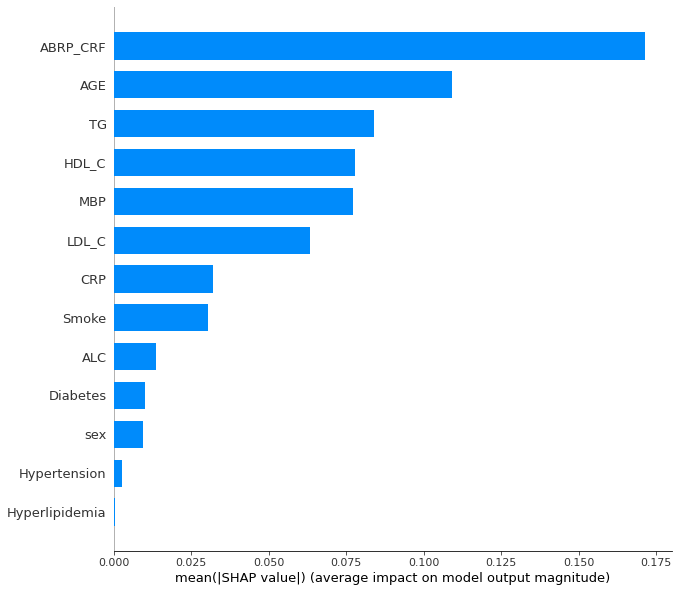

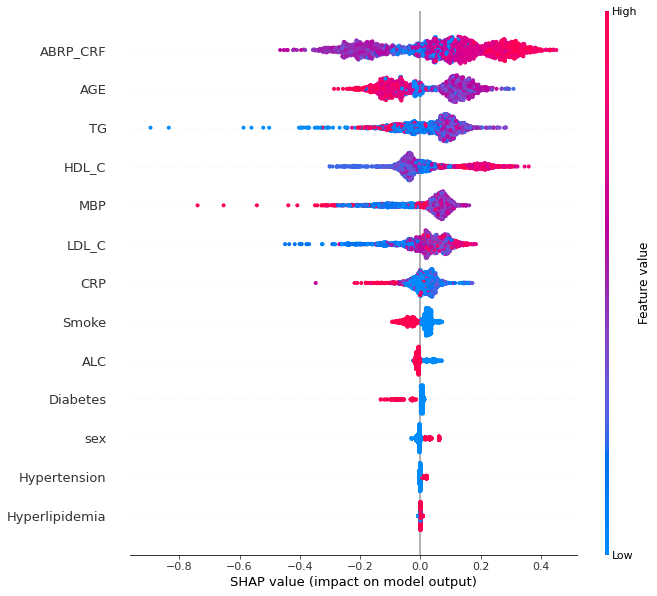

In [10]:
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=feature_names, plot_size=(10, 10))

shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(10, 10))